In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from category_encoders import BinaryEncoder
from sklearn.dummy import DummyRegressor

In [2]:
df = pd.read_csv(filepath_or_buffer='rome_listings_aftereda.csv')

In [3]:
df.shape

(22817, 10)

In [4]:
df.columns

Index(['neighbourhood_cleansed', 'longitude', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bathrooms_shared',
       'logprice'],
      dtype='object')

In [5]:
## One Hot encoding for room_type
df = pd.get_dummies(df, columns=['room_type'], prefix='room_type')
df = pd.get_dummies(df, columns=['neighbourhood_cleansed'], prefix='neighbourhood')

In [6]:
## convert boolean columns to int
bool_cols = df.columns[df.dtypes == 'bool']
df[bool_cols] = df[bool_cols].astype(int)

In [7]:
binary_encoder = BinaryEncoder()
binary_encoder.fit_transform(df['property_type'])
# Create a DataFrame with the new columns
new_columns = pd.DataFrame(binary_encoder.transform(df['property_type']), columns=binary_encoder.get_feature_names_out())

# Concatenate the new columns with the original dataset
df = pd.concat([df, new_columns], axis=1)
df.drop(columns=['property_type'], inplace=True)

In [8]:
price = np.log(df.pop('logprice'))

In [9]:
df.columns

Index(['longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bathrooms_shared', 'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'neighbourhood_I Centro Storico', 'neighbourhood_II Parioli/Nomentano',
       'neighbourhood_III Monte Sacro', 'neighbourhood_IV Tiburtina',
       'neighbourhood_IX Eur', 'neighbourhood_V Prenestino/Centocelle',
       'neighbourhood_VI Roma delle Torri',
       'neighbourhood_VII San Giovanni/Cinecittà',
       'neighbourhood_VIII Appia Antica', 'neighbourhood_X Ostia/Acilia',
       'neighbourhood_XI Arvalia/Portuense', 'neighbourhood_XII Monte Verde',
       'neighbourhood_XIII Aurelia', 'neighbourhood_XIV Monte Mario',
       'neighbourhood_XV Cassia/Flaminia', 'property_type_0',
       'property_type_1', 'property_type_2', 'property_type_3',
       'property_type_4', 'property_type_5'],
      dtype='object')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df, price, test_size=0.3, random_state=42, shuffle=True)

In [11]:
columns_to_standardize = ['accommodates', 'bathrooms', 'bedrooms', 'beds']
scaler = StandardScaler()
X_train[columns_to_standardize] = scaler.fit_transform(X_train[columns_to_standardize])
X_test[columns_to_standardize] = scaler.transform(X_test[columns_to_standardize])

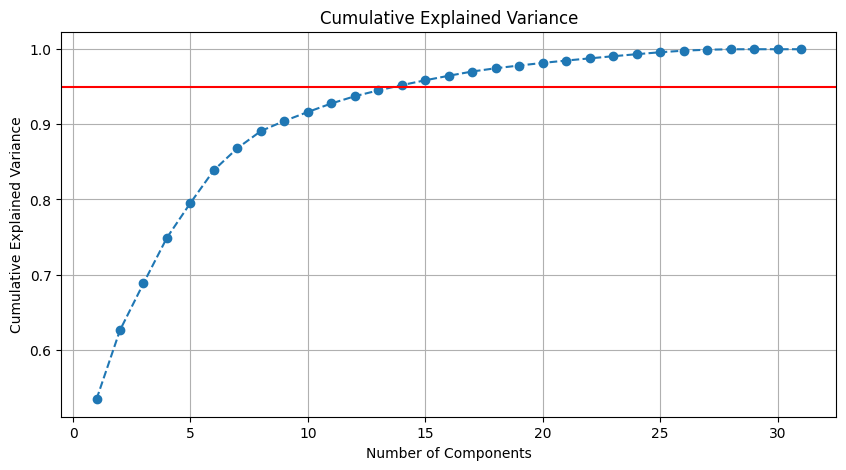

Number of components chosen: 14


In [12]:
# Step 3: Perform PCA
threshold = 0.95
pca = PCA()
pca.fit(X_train)

# Step 4: Calculate explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Step 5: Plot the cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=threshold, color='r', linestyle='-')  # Line for threshold
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Step 6: Determine the number of components

n_components = np.argmax(cumulative_variance >= threshold) + 1
print(f"Number of components chosen: {n_components}")

In [13]:
pca = PCA(n_components=n_components)
X_train_transform = pca.fit_transform(X_train)
X_test_transform = pca.transform(X_test)

In [14]:
# Linear Regression
param_grid = {}
scoring = make_scorer(mean_squared_error, greater_is_better=False)
model = LinearRegression()
grid_search_linreg = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scoring,
    cv=KFold(5, random_state=2, shuffle=True),
    n_jobs=-1
)
grid_search_linreg.fit(X_train_transform, y_train)
print("Best parameters found: ", grid_search_linreg.best_params_)
print("Best mean squared error: ", -grid_search_linreg.best_score_)

Best parameters found:  {}
Best mean squared error:  0.008641527988522673


In [15]:

alphas = np.logspace(-6, 6, 100, base=10)
param_grid = {'alpha': alphas}
scoring = make_scorer(mean_squared_error, greater_is_better=False)
model = Ridge()
grid_search_ridge = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scoring,
    cv=KFold(5, random_state=2, shuffle=True),
    n_jobs=-1
)
grid_search_ridge.fit(X_train, y_train)
print("Best parameters found: ", grid_search_ridge.best_params_)
print("Best mean squared error: ", -grid_search_ridge.best_score_)


Best parameters found:  {'alpha': 2.009233002565046}
Best mean squared error:  0.008380203343526665


In [16]:
alphas = np.logspace(-6, 6, 100, base=10)
param_grid = {'alpha': alphas, 'max_iter':[2000],'tol':[1e-3]}
model = Lasso()
grid_search_lasso = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scoring,
    cv=KFold(5, random_state=2, shuffle=True),
    n_jobs=-1
)
grid_search_lasso.fit(X_train, y_train)
print("Best parameters found: ", grid_search_lasso.best_params_)
print("Best mean squared error: ", -grid_search_lasso.best_score_)

/home/lorenzobonanni/Desktop/UNI/MAGISTRALE/STATISTICAL LEARNING/PROGETTO/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.331e+00, tolerance: 2.089e-01
  model = cd_fast.enet_coordinate_descent(
/home/lorenzobonanni/Desktop/UNI/MAGISTRALE/STATISTICAL LEARNING/PROGETTO/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.361e+00, tolerance: 2.061e-01
  model = cd_fast.enet_coordinate_descent(
/home/lorenzobonanni/Desktop/UNI/MAGISTRALE/STATISTICAL LEARNING/PROGETTO/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: Conver

Best parameters found:  {'alpha': 1.2328467394420658e-05, 'max_iter': 2000, 'tol': 0.001}
Best mean squared error:  0.008380349894482686


In [17]:
# Decision Tree
param_grid = param_grid = {
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    'ccp_alpha': [0.0, 0.1, 0.2],
    'random_state': [2]  # Adjust this according to your needs
}
model = DecisionTreeRegressor()
grid_search_dt = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scoring,
    cv=KFold(5, random_state=2, shuffle=True),
    n_jobs=-1,
    verbose=1
)
grid_search_dt.fit(X_train, y_train)
print("Best parameters found: ", grid_search_dt.best_params_)
print("Best mean squared error: ", -grid_search_dt.best_score_)

Fitting 5 folds for each of 2430 candidates, totalling 12150 fits
Best parameters found:  {'ccp_alpha': 0.0, 'max_depth': 10, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'random_state': 2, 'splitter': 'random'}
Best mean squared error:  0.008365593212622386


In [18]:
# Random Forest
param_grid = param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
model = RandomForestRegressor()
grid_search_rf = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scoring,
    cv=KFold(5, random_state=2, shuffle=True),
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X_train, y_train)
print("Best parameters found: ", grid_search_rf.best_params_)
print("Best mean squared error: ", -grid_search_rf.best_score_)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


/home/lorenzobonanni/Desktop/UNI/MAGISTRALE/STATISTICAL LEARNING/PROGETTO/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/lorenzobonanni/Desktop/UNI/MAGISTRALE/STATISTICAL LEARNING/PROGETTO/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
514 fits failed with the following error:
Traceback (most recent call last):
  File "/home/lorenzobonanni/Desktop/UNI/MAGISTRALE/STATISTICAL LEARNING/PROGETTO/.venv/lib/

Best parameters found:  {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best mean squared error:  0.007438763238470239


In [31]:
# XGBoost
param_grid = param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
}
model = xgb.XGBRegressor(random_state=2)
grid_search_xgb = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scoring,
    cv=KFold(5, random_state=2, shuffle=True),
    n_jobs=-1
)
grid_search_xgb.fit(X_train, y_train)
print("Best parameters found: ", grid_search_xgb.best_params_)
print("Best mean squared error: ", -grid_search_xgb.best_score_)

Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 100}
Best mean squared error:  0.007391757619679635


In [36]:
dummy_reg_mean = DummyRegressor(strategy='mean')
dummy_reg_mean.fit(X_train, y_train)

DummyRegressor()

In [37]:
# Evaluate the best model
performance = {}
trained = {
    'Ridge': grid_search_ridge.best_estimator_,
    'RandomForest': grid_search_rf.best_estimator_,
    'XGBoost': grid_search_xgb.best_estimator_,
    'DecisionTree': grid_search_dt.best_estimator_,
    'Dummy_mean': dummy_reg_mean
}
for name, model in trained.items():
    predictions = model.predict(X_test)
    mse = mean_squared_error(np.exp(y_test), np.exp(predictions))
    rmse = np.sqrt(mse)
    performance[name] = mse
    print(f"{name} mean squared error: {mse}", f"root mean squared error: {rmse}")

Ridge mean squared error: 0.21052568865209004 root mean squared error: 0.45883078433349483
RandomForest mean squared error: 0.18319372928842148 root mean squared error: 0.42801136584023264
XGBoost mean squared error: 0.18152150125722089 root mean squared error: 0.4260534018843423
DecisionTree mean squared error: 0.20172878298189845 root mean squared error: 0.4491422747659125
Dummy_mean mean squared error: 0.39761676978403265 root mean squared error: 0.630568608308432


In [38]:
model = grid_search_linreg.best_estimator_
name = "Linear Regression"
X_test_transform = pca.transform(X_test)
predictions = model.predict(X_test_transform)
mse = mean_squared_error(np.exp(y_test), np.exp(predictions))
rmse = np.sqrt(mse)
performance[name] = mse
print(f"{name} mean squared error: {mse}", f"root mean squared error: {rmse}")

Linear Regression mean squared error: 0.2154898252214036 root mean squared error: 0.4642088163977539


<Axes: >

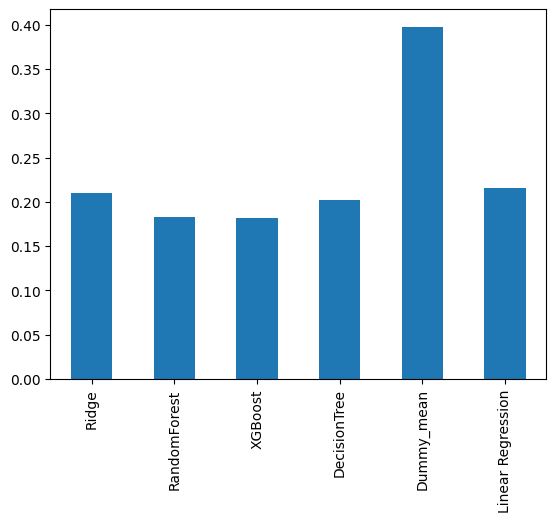

In [39]:
pd.Series(performance).plot(kind='bar')

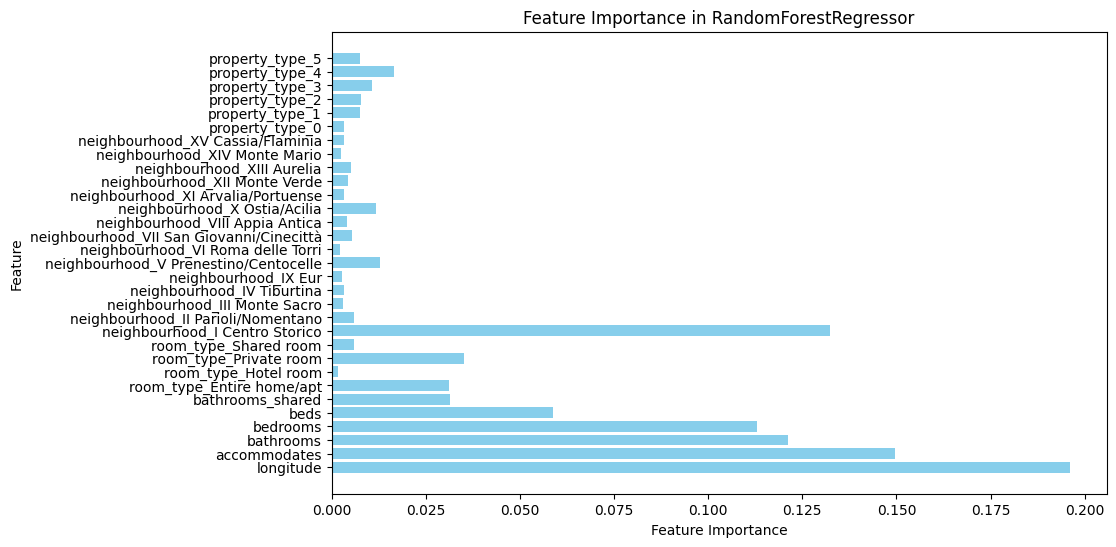

In [45]:
importances = grid_search_rf.best_estimator_.feature_importances_
feature_names = X_train.columns

# Step 6: Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in RandomForestRegressor')
plt.show()
